# 병렬처리 워크플로 구현 : 날씨, 뉴스, 주식 병렬 처리

In [ ]:
# 왜 병렬 처리 필요?
# LLM 호출 실행, API 호출, DB 접근, 파일 처리...  <- 처리시간이 오래 걸리는 작업
# 이런작업들은 '순차적'으로 실행하면 느리다!
# 병렬로 동시제 실행하여 워크플로의 성능을 극대화.

# 랭그래프는 각 노드들을 '독립적'으로 실행 할수도 있다!
# 다른 노드에 의존성이 없는 노드는 자동적으로 병렬 실행 할수 있게 됩니다

# import

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing import Dict, Any
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel
import time
import random
from IPython.display import Image, display

# 상태 정의

In [3]:
class DashboardState(BaseModel):
    user_location: str = "서울"  # 사용자의 위치
    weather_data: Dict[str, Any] = {}  # 날씨 데이터
    news_data: Dict[str, Any] = {}   # 뉴스 데이터
    stock_data: Dict[str, Any] = {}  # 주식 관련 데이터
    dashboard_report: str = ""   # 대시보드 리포트
    start_time: float = 0.0   # 대시보드 생성시각

# 코디네이터 노드
- 병렬처리의 시작점 역할
- 시작시간을 업데이트 하여 전체 실행 시간 측정에 사용할거다.

In [4]:
def coordinator(state: DashboardState) -> Dict[str, Any]:
    print(f"대시 보드 생성 시작 - 위치: {state.user_location}")
    return {"start_time": time.time()}  # 시작시간 업데이트

# 병렬 실행할 노드(들)

## 날씨 데이터 수집

In [11]:
def weather_checker(state: DashboardState) -> Dict[str, Any]:
    print('날씨 확인 중...')
    time.sleep(random.uniform(1.0, 2.0))  # 딜레이

    weather_info = {
        "location": state.user_location,
        "condition": "맑음",
        "temperature": 22,
        "humidity": 65,
    }

    print(f"날씨: {weather_info['condition']}, {weather_info['temperature']}°C")
    return {"weather_data": weather_info}

    

## 뉴스 데이터 수집

In [12]:
def news_fetcher(state: DashboardState) -> Dict[str, Any]:
    print("뉴스 수집 중...")
    time.sleep(random.uniform(1.5, 2.5))

    news_info = {
        "articles": [
            {"title": "AI 기술 발전 소식", "summary": "AI 분야 새로운 혁신"},
            {"title": "경제 동향 분석", "summary": "글로벌 경제 전망"},
        ],
        "count": 2,
    }

    print(f"뉴스 {news_info['count']}개 수집 완료")
    return {"news_data": news_info}    

## 주식 데이터 분석

In [13]:
def stock_analyzer(state: DashboardState) -> Dict[str, Any]:
    print("주식 분석 중...")
    time.sleep(random.uniform(2.0, 3.0))

    stock_info = {
        "KOSPI": {"price": 2650.5, "change": +1.2},
        "NASDAQ": {"price": 15780.3, "change": -0.8},
    }

    print("주식 분석 완료")
    return {"stock_data": stock_info}    

# 집계 노드
- 모든 병렬 실행 노드들의 작업이 끝나면 집계 노드에서 수집된 데이터를 종합하여 리포트 생성
- 전체 실행시간을 계산

In [14]:
def aggregator(state: DashboardState) -> Dict[str, Any]:
    print("리포트 생성 중...")
    parallel_time = time.time() - state.start_time  # 전체 실행시간 (경과시간) 계산

    report = f"""
대시보드 리포트
날씨: {state.weather_data.get("condition", "N/A")} {state.weather_data.get("temperature", "N/A")}°C
뉴스: {state.news_data.get("count", 0)}개 기사
주식: KOSPI {state.stock_data.get("KOSPI", {}).get("price", "N/A")}
실행시간: {parallel_time:.1f}초    
    """

    print(f"대시보드 완료 ({parallel_time:.1f}초)")
    return {"dashboard_report": report}

# 그래프 생성

In [15]:
def create_graph():
    workflow = StateGraph(DashboardState)

    workflow.add_node("coordinator", coordinator)
    workflow.add_node("weather", weather_checker)
    workflow.add_node("news", news_fetcher)
    workflow.add_node("stock", stock_analyzer)
    workflow.add_node("aggregator", aggregator)

    # 병렬 실행 구조
    # 병렬실행 처리는 랭그래프가 알아서 한다.
    workflow.add_edge(START, "coordinator")
    workflow.add_edge("coordinator", "weather")
    workflow.add_edge("coordinator", "news")
    workflow.add_edge("coordinator", "stock")

    workflow.add_edge("weather", "aggregator")
    workflow.add_edge("news", "aggregator")
    workflow.add_edge("stock", "aggregator")

    workflow.add_edge("aggregator", END)

    return workflow.compile()
    

# 실행

In [16]:
app = create_graph()

initial_state = DashboardState(user_location="부산")
print("병렬 실행 시작!")

result = app.invoke(initial_state)

print("\n최종 결과:")
print(result["dashboard_report"])


병렬 실행 시작!
대시 보드 생성 시작 - 위치: 부산
뉴스 수집 중...
주식 분석 중...
날씨 확인 중...
날씨: 맑음, 22°C
뉴스 2개 수집 완료
주식 분석 완료
리포트 생성 중...
대시보드 완료 (2.4초)

최종 결과:

대시보드 리포트
날씨: 맑음 22°C
뉴스: 2개 기사
주식: KOSPI 2650.5
실행시간: 2.4초    
    


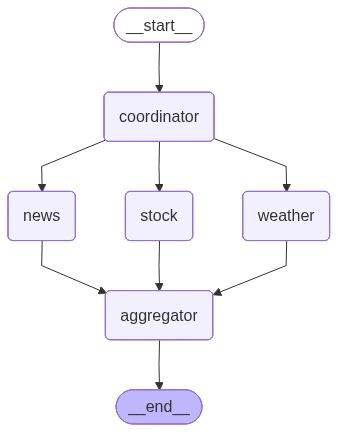

In [17]:
Image(app.get_graph().draw_mermaid_png())